**결측치 채우는 방법**
- 만약 년도/도시를 기준으로 하면 test set에서 데이터 전처리를 진행할 때 test set의 데이터를 참고하게 될 수 밖에 없음
    - 각 년도/도시/라벨/인종/성별 별로 하나의 데이터 씩 밖에 없기 때문
- 년도와 다르게 도시는 가까운 도시를 정의할 방법이 필요
    - 혹은 U.S. Total의 값을 적용하는 방법이 있음
- 도시간 거리를 정의한다면
    - 각 (인종,성별,도시,연도) tuple 별로 각 라벨에서의 데이터 값에 대해서 sppt에서의 거리와 label value에서의 거리 사이에 비교
    - sppt 에서의 metric
        - 각각의 차원에서의 거리를 규정한 뒤, 각 차원에서의 거리를 euclidean 
        - 기타 방법이 가능할 수 있으나 데이터의 양을 봤을 때 쉽지 않을 듯
        - 인종, 성별 : all, both 와의 거리는 다른 집단과의 거리보다 짧게
        - 도시 : 도시에 대한 geo_strata 정보를 기준으로 metric 정의
            - geo_strata의 feature : region, poverty, population, popDensity, segration
            - 추가적으로 feature를 더한다면 : 내륙/해안/접경, 위도경도
            - geo_strata의 값이 연도 별로 달라지는 지 확인
        - 연도 : 차이

- 각 label 별로 예측 학습을 진행하여 전처리에 이용할 수도 있음
    - race-sex에 따른 차이에 경향성이 유사한 것들끼리 묶어서 하는 것 가능하면 의미 있을지도
    - category 혹은 sub category 별로 변화 사이에서 correlation을 보는 등
    - 혹은 특정 label에 대해서 학습을 진행한 뒤, 다른 label에 그대로 적용


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns 
import os

In [2]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})

In [3]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[fm.FontProperties(fname=font).get_name() for font in font_list if 'D2C' in font]
plt.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
DATASET_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/dataset/'
load_dir = 'america_big_cities_health_inventory'
file_name = 'BigCitiesHealth.csv'
RSLT_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/1.project1_structured/BCHI/processed/'
pvtb_dir = RSLT_DIR + 'pvtb/'

## FUNCTIONS

- preprocess

In [5]:
def count_key_opt(data:pd.DataFrame,key,opt):
    rslt = dict()
    labels = data[key].unique()
    form = data[opt].value_counts().sort_values(ascending=False)
    form.iloc[:] = 0

    for feat in labels:
        cond = data[key]==feat
        val = form.copy()
        temp = data.loc[cond,opt].value_counts()
        val.loc[temp.index] = temp
        rslt[feat] = val

    return pd.DataFrame(rslt).T

In [6]:
import functools

def cond_check_dict(data=pd.DataFrame,val_dict=dict):
    cond_list=[
        data[col] == val
        for col, val in val_dict.items()
    ]
    return functools.reduce(lambda x,y: x & y, cond_list)

- plot

In [7]:
import re

def choose_split_point(word_len,space,ths):
    # 윗 줄에 space 만큼 공백이 있고, 한 줄의 길이가 ths로 제한 되어있을 때
    # 어떤 지점에서 단어를 끊어줄지 정하기
    # |-------ths-------|
    # |-space-|---------|-space-|------| : word
    #         |-------ths-------|
    print(word_len,space,ths)
    if word_len < ths + space :
        if abs(word_len/2 -ths) <= abs(word_len/2-space) :
            return word_len-ths
        else :
            return word_len - space if word_len < 2 * space else space
    else :
        return ths if word_len - (ths + space) < 0.3 * ths else space

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e) 
    return rslt

def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]
#알고리즘 때문에 맨 앞에 빈칸 하나 들어가게 되는 이슈 있음

print(str_cutter('Racial Segregation Indices | Racial Segregation, White and Hispanic', 13))



Racial
Segregation
Indices |
Racial
Segregation,
White and
Hispanic


In [466]:
def choose_plot_grid(n:int,r_max=8,c_max=17,res_ths=2):
    #ver2
    r_min = np.ceil(n/c_max)
    sppt = np.arange(r_min,r_max+1) #need error process
    col_nums = np.ceil(n/sppt)
    res = col_nums * sppt -n
    min_idx = np.where((res==np.min(res)) | (res <= res_ths))[0]
    row_cand, col_cand = sppt[min_idx], col_nums[min_idx]
    if len(min_idx) > 1 :
        res = np.abs(row_cand-col_cand)
        i = np.where(res==np.min(res))[0][0]
    else : i = 0
    return int(row_cand[i]), int(col_cand[i])


def pair_plot_feat_hue(fig,axes,data:dict,pair_plot,axis_share=False,hue_label_dict=None, **kwargs):
    #ver2
    if (fig is None) or (axes is None) :
        num_r, num_c = choose_plot_grid(len(data))
        fig, axes = plt.subplots(num_r,num_c,figsize=(21,17),sharex=axis_share,sharey=axis_share)
    for n,key in enumerate(data.keys()):
        ax = axes.flatten()[n]
        plt.setp(ax.get_xticklabels(),ha = 'left',rotation = 90)
        if n >= len(data) : continue
        pair_plot(x=data[key][0], y = data[key][1],ax =ax, **kwargs)
        feat_name = str(key) 
        if hue_label_dict: color = 'b' if hue_label_dict[feat_name] else 'k'
        else : color = 'k'
        ax.set_xlabel(str_cutter(feat_name,20),loc='left',fontsize = 8.3,color=color)
    return fig,axes

In [277]:
choose_plot_grid(5)

(2, 3)

# Define metic on a support $X$

- 숫자들 간에는 차의 절대값으로 하면 됨
- categorical의 경우
    - geo : ordinal이라 볼 수 있지만 binary
    - race, sex : nominal이지만 중간값(all or both) 존재

In [9]:
raw_file_path = os.path.join(DATASET_DIR,load_dir,file_name)
df_raw = pd.read_csv(raw_file_path)

df_raw

/tmp/ipykernel_9847/1273264358.py:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(raw_file_path)


,metric_item_label,metric_cat_label,metric_subcat_label,metric_item_label_subtitle,metric_cat_item_yaxis_label,metric_source_desc_label_fn,metric_source_desc_label_url_fn,geo_label_city,geo_label_state,geo_label_citystate,...,value_90_ci_low,value_90_ci_high,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,strata_race_label,strata_sex_label,strata_race_sex_label
0,All Cancer Deaths,Chronic Health Conditions,Cancer,"Deaths from all types of cancer (per 100,000 p...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Cleveland,OH,"Cleveland, OH",...,NaN,NaN,Midwest,Poorest cities (18%+ poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),Black,Female,Black Female
1,All Cancer Deaths,Chronic Health Conditions,Cancer,"Deaths from all types of cancer (per 100,000 p...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Oakland,CA,"Oakland, CA",...,NaN,NaN,West,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),Hispanic,Male,Hispanic Male
2,All Cancer Deaths,Chronic Health Conditions,Cancer,"Deaths from all types of cancer (per 100,000 p...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,San Francisco,CA,"San Francisco, CA",...,NaN,NaN,West,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Less Segregated (<50%),All,Female,NaN
3,All Cancer Deaths,Chronic Health Conditions,Cancer,"Deaths from all types of cancer (per 100,000 p...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Long Beach,CA,"Long Beach, CA",...,NaN,NaN,West,Less poor cities (<18% poor),Smaller (<1.3 million),Smaller (<1.3 million),Highly Segregated (50%+),Hispanic,Female,Hispanic Female
4,All Cancer Deaths,Chronic Health Conditions,Cancer,"Deaths from all types of cancer (per 100,000 p...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Cleveland,OH,"Cleveland, OH",...,NaN,NaN,Midwest,Poorest cities (18%+ poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),Black,Male,Black Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189974,"Racial Segregation, White and Hispanic",Social and Economic Factors,Racial Segregation Indices,Residential segregation of white non-Hispanic ...,Lower is better,"American Community Survey, U.S. Census Bureau",https://www.census.gov/programs-surveys/acs,Chicago,IL,"Chicago, IL",...,NaN,NaN,Midwest,Less poor cities (<18% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),All,Both,NaN
189975,"Racial Segregation, White and Hispanic",Social and Economic Factors,Racial Segregation Indices,Residential segregation of white non-Hispanic ...,Lower is better,"American Community Survey, U.S. Census Bureau",https://www.census.gov/programs-surveys/acs,Charlotte,NC,"Charlotte, NC",...,NaN,NaN,South,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),All,Both,NaN
189976,"Racial Segregation, White and Hispanic",Social and Economic Factors,Racial Segregation Indices,Residential segregation of white non-Hispanic ...,Lower is better,"American Community Survey, U.S. Census Bureau",https://www.census.gov/programs-surveys/acs,Boston,MA,"Boston, MA",...,NaN,NaN,Northeast,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),All,Both,NaN
189977,"Racial Segregation, White and Hispanic",Social and Economic Factors,Racial Segregation Indices,Residential segregation of white non-Hispanic ...,Lower is better,"American Community Survey, U.S. Census Bureau",https://w

In [10]:
cond_US = cond_check_dict(df_raw,{"geo_label_city":"U.S. Total"})
df_city = df_raw[~cond_US]

df_city

,metric_item_label,metric_cat_label,metric_subcat_label,metric_item_label_subtitle,metric_cat_item_yaxis_label,metric_source_desc_label_fn,metric_source_desc_label_url_fn,geo_label_city,geo_label_state,geo_label_citystate,...,value_90_ci_low,value_90_ci_high,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,strata_race_label,strata_sex_label,strata_race_sex_label
0,All Cancer Deaths,Chronic Health Conditions,Cancer,"Deaths from all types of cancer (per 100,000 p...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Cleveland,OH,"Cleveland, OH",...,NaN,NaN,Midwest,Poorest cities (18%+ poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),Black,Female,Black Female
1,All Cancer Deaths,Chronic Health Conditions,Cancer,"Deaths from all types of cancer (per 100,000 p...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Oakland,CA,"Oakland, CA",...,NaN,NaN,West,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),Hispanic,Male,Hispanic Male
2,All Cancer Deaths,Chronic Health Conditions,Cancer,"Deaths from all types of cancer (per 100,000 p...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,San Francisco,CA,"San Francisco, CA",...,NaN,NaN,West,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Less Segregated (<50%),All,Female,NaN
3,All Cancer Deaths,Chronic Health Conditions,Cancer,"Deaths from all types of cancer (per 100,000 p...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Long Beach,CA,"Long Beach, CA",...,NaN,NaN,West,Less poor cities (<18% poor),Smaller (<1.3 million),Smaller (<1.3 million),Highly Segregated (50%+),Hispanic,Female,Hispanic Female
4,All Cancer Deaths,Chronic Health Conditions,Cancer,"Deaths from all types of cancer (per 100,000 p...","Per 100,000","National Vital Statistics System (NVSS), Cente...",https://www.cdc.gov/nchs/nvss/index.htm,Cleveland,OH,"Cleveland, OH",...,NaN,NaN,Midwest,Poorest cities (18%+ poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),Black,Male,Black Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189974,"Racial Segregation, White and Hispanic",Social and Economic Factors,Racial Segregation Indices,Residential segregation of white non-Hispanic ...,Lower is better,"American Community Survey, U.S. Census Bureau",https://www.census.gov/programs-surveys/acs,Chicago,IL,"Chicago, IL",...,NaN,NaN,Midwest,Less poor cities (<18% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),All,Both,NaN
189975,"Racial Segregation, White and Hispanic",Social and Economic Factors,Racial Segregation Indices,Residential segregation of white non-Hispanic ...,Lower is better,"American Community Survey, U.S. Census Bureau",https://www.census.gov/programs-surveys/acs,Charlotte,NC,"Charlotte, NC",...,NaN,NaN,South,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),All,Both,NaN
189976,"Racial Segregation, White and Hispanic",Social and Economic Factors,Racial Segregation Indices,Residential segregation of white non-Hispanic ...,Lower is better,"American Community Survey, U.S. Census Bureau",https://www.census.gov/programs-surveys/acs,Boston,MA,"Boston, MA",...,NaN,NaN,Northeast,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),All,Both,NaN
189977,"Racial Segregation, White and Hispanic",Social and Economic Factors,Racial Segregation Indices,Residential segregation of white non-Hispanic ...,Lower is better,"American Community Survey, U.S. Census Bureau",https://w

### metric on geo_strat
- abstract geo_strat

In [11]:
geo_strat_cols = list(filter(lambda x : 'geo_strat' in x,df_city.columns))
geo_info_cols = list(filter(lambda x : 'geo_label' in x,df_city.columns))[:3]

df_temp = df_city[geo_info_cols+geo_strat_cols]

df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188667 entries, 0 to 189978
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   geo_label_city          188667 non-null  object
 1   geo_label_state         188667 non-null  object
 2   geo_label_citystate     188667 non-null  object
 3   geo_strata_region       188667 non-null  object
 4   geo_strata_poverty      188667 non-null  object
 5   geo_strata_Population   188666 non-null  object
 6   geo_strata_PopDensity   188667 non-null  object
 7   geo_strata_Segregation  188667 non-null  object
dtypes: object(8)
memory usage: 13.0+ MB


In [12]:
# EDA 결과, las vegas와 long beach에 대해서 오기입된 record가 하나씩 있음
# 오기입된 outlier을 제외하고 반복되어 등장한 것만 추림
dup_cond = df_temp.duplicated(keep=False)
print(len(df_temp[dup_cond].value_counts()))
#df_temp[dup_cond].value_counts()

35


In [13]:
df_geo_strat = df_temp[dup_cond].value_counts().reset_index()

In [14]:
df_geo_info = df_geo_strat.set_index('geo_label_city')

df_geo_info

,geo_label_state,geo_label_citystate,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,count
geo_label_city,,,,,,,,
New York City,NY,"New York City, NY",Northeast,Less poor cities (<18% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6535
Houston,TX,"Houston, TX",South,Poorest cities (18%+ poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),6431
Los Angeles,CA,"Los Angeles, CA",West,Less poor cities (<18% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),6372
Philadelphia,PA,"Philadelphia, PA",Northeast,Poorest cities (18%+ poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6310
San Diego,CA,"San Diego, CA",West,Less poor cities (<18% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),6251
Chicago,IL,"Chicago, IL",Midwest,Less poor cities (<18% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6210
San Francisco,CA,"San Francisco, CA",West,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Less Segregated (<50%),6121
Las Vegas,NV,"Las Vegas, NV",West,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),5848
Boston,MA,"Boston, MA",Northeast,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),5718


In [15]:
save_path = os.path.join(RSLT_DIR,'geo_strat_info.csv')
df_geo_info.to_csv(save_path,index=True)

- except for geo_strata_region, all of them is ordinal and binary
- in geo_strata_region, minimal length between each regions could be base of metric
    - a condition of metric :

        (distance between a, c) <= (distance between a, b) + (distance between b, c)

In [16]:
df_region = df_geo_strat.groupby('geo_strata_region')['geo_label_state'].apply(set)

df_region

geo_strata_region
Midwest      {IN, IL, MI, WI, OH, MN, MO}
Northeast                    {MA, PA, NY}
South        {TN, OK, TX, KY, NC, MD, DC}
West             {AZ, CA, WA, NV, OR, CO}
Name: geo_label_state, dtype: object

In [17]:
df_geo_strat[geo_strat_cols].value_counts()

geo_strata_region  geo_strata_poverty            geo_strata_Population   geo_strata_PopDensity                  geo_strata_Segregation  
West               Less poor cities (<18% poor)  Smaller (<1.3 million)  Lower pop. density (<10k per sq mi)    Less Segregated (<50%)      6
South              Less poor cities (<18% poor)  Smaller (<1.3 million)  Lower pop. density (<10k per sq mi)    Less Segregated (<50%)      5
Midwest            Less poor cities (<18% poor)  Smaller (<1.3 million)  Lower pop. density (<10k per sq mi)    Less Segregated (<50%)      4
                   Poorest cities (18%+ poor)    Smaller (<1.3 million)  Lower pop. density (<10k per sq mi)    Highly Segregated (50%+)    3
South              Poorest cities (18%+ poor)    Smaller (<1.3 million)  Lower pop. density (<10k per sq mi)    Highly Segregated (50%+)    2
West               Less poor cities (<18% poor)  Largest (>1.3 million)  Lower pop. density (<10k per sq mi)    Highly Segregated (50%+)    2
           

In [18]:
for col in geo_strat_cols:
    display(df_geo_strat[col].value_counts())

geo_strata_region
South        12
West         12
Midwest       8
Northeast     3
Name: count, dtype: int64

geo_strata_poverty
Less poor cities (<18% poor)    26
Poorest cities (18%+ poor)       9
Name: count, dtype: int64

geo_strata_Population
Smaller (<1.3 million)    26
Largest (>1.3 million)     9
Name: count, dtype: int64

geo_strata_PopDensity
Lower pop. density (<10k per sq mi)      29
Highest pop. density (>10k per sq mi)     6
Name: count, dtype: int64

geo_strata_Segregation
Less Segregated (<50%)      20
Highly Segregated (50%+)    15
Name: count, dtype: int64

basically,
- if a,b are adjacent : d(a,b) = 1
- if minimal path == 2 : d(a,b) = 1.732 (cf. sqrt 3)

(cf : 정삼각형 2 개 붙어있는 모양)

In [19]:
import itertools

region_adjacent = [
    { "Midwest", "Northeast" },
    { "Midwest", "South" },
    { "Midwest", "West" },
    { "West", "South" },
    { "South", "Northeast" }
]

    
def metric_on_adj(points,adjacents,far_distance = 1.732):
    metric_dict=dict()
    for a,b in itertools.product(points,repeat=2):
        if a == b : metric_dict[(a,b)] = 0
        elif {a,b} in adjacents : metric_dict[(a,b)] = 1
        else : metric_dict[(a,b)] = far_distance 
    return lambda x,y : metric_dict[(x,y)]

metric_region = metric_on_adj(df_region.index,region_adjacent)

print(type(metric_region))
print(metric_region('West','Northeast'))

<class 'function'>
1.732


the algorithm could be applied on other nominal categories, e.g. race, sex, and other binay ordinal categories.

In [20]:
metric_binary = lambda x,y : 0 if x==y else 1
# metric_binary.__setattr__('name','metric_binary') -> 함수에 이름 정해주는 법 어떻게?

entire_race = ['All','White','Black','Hispanic','Asian/PI','Natives']
race_adjacnet = [
    {'All', a}
    for a in entire_race
    if a != 'All'
]
metric_race = metric_on_adj(entire_race, race_adjacnet)

entire_sex = ['Both','Female','Male']
sex_adjacnet = [
    {'Both', a}
    for a in entire_race
    if a != 'Both'
]
metric_sex = metric_on_adj(entire_sex, sex_adjacnet)

metric_race('White','Black')

1.732

In [21]:
dict_metric = dict()

dict_metric['strata_race_label'] = metric_race
dict_metric['strata_sex_label'] = metric_sex
dict_metric['geo_strata_region'] = metric_region

for col in geo_strat_cols:
    if col == 'geo_strata_region' : continue
    dict_metric[col] = metric_binary

dict_metric

{'strata_race_label': <function __main__.metric_on_adj.<locals>.<lambda>(x, y)>,
 'strata_sex_label': <function __main__.metric_on_adj.<locals>.<lambda>(x, y)>,
 'geo_strata_region': <function __main__.metric_on_adj.<locals>.<lambda>(x, y)>,
 'geo_strata_poverty': <function __main__.<lambda>(x, y)>,
 'geo_strata_Population': <function __main__.<lambda>(x, y)>,
 'geo_strata_PopDensity': <function __main__.<lambda>(x, y)>,
 'geo_strata_Segregation': <function __main__.<lambda>(x, y)>}

In [22]:
dict_metric['geo_strata_Segregation'].__name__

'<lambda>'

In [23]:
dict_metric['geo_strata_region'] ('Midwest','Midwest')

0

In [24]:
dict_metric['strata_race_label'] ('All','White')

1

### distance between cities
- 각 axis 에서의 거리를 L7 norm 한 것으로 테스트
- 7은 임의로 정한 것으로 필요시 다른 값으로 테스트 해봐도 좋을 듯

In [25]:
df_geo_info

,geo_label_state,geo_label_citystate,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,count
geo_label_city,,,,,,,,
New York City,NY,"New York City, NY",Northeast,Less poor cities (<18% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6535
Houston,TX,"Houston, TX",South,Poorest cities (18%+ poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),6431
Los Angeles,CA,"Los Angeles, CA",West,Less poor cities (<18% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),6372
Philadelphia,PA,"Philadelphia, PA",Northeast,Poorest cities (18%+ poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6310
San Diego,CA,"San Diego, CA",West,Less poor cities (<18% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),6251
Chicago,IL,"Chicago, IL",Midwest,Less poor cities (<18% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6210
San Francisco,CA,"San Francisco, CA",West,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Less Segregated (<50%),6121
Las Vegas,NV,"Las Vegas, NV",West,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),5848
Boston,MA,"Boston, MA",Northeast,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),5718


In [26]:
print(metric_region('Northeast', 'Northeast'))

0


In [27]:
print(dict_metric['geo_strata_region']('Northeast', 'Northeast'))

0


In [28]:
city_list = list(df_geo_info.index)

metric_val= dict()
for a, b in itertools.product(city_list,repeat=2):
    diff = [
        dict_metric[col](df_geo_info.loc[a,col],
                         df_geo_info.loc[b,col])
        for col in geo_strat_cols
        ]
    metric_val[(a,b)] = np.linalg.norm(np.array(diff),ord=7)
    
metric_val 

{('New York City', 'New York City'): 0.0,
 ('New York City', 'Houston'): 1.169930812758687,
 ('New York City', 'Los Angeles'): 1.7372440623952268,
 ('New York City', 'Philadelphia'): 1.0,
 ('New York City', 'San Diego'): 1.7423948319061235,
 ('New York City', 'Chicago'): 1.0,
 ('New York City', 'San Francisco'): 1.7423948319061235,
 ('New York City', 'Las Vegas'): 1.7474558315662452,
 ('New York City', 'Boston'): 1.0,
 ('New York City', 'Oakland'): 1.7474558315662452,
 ('New York City', 'Dallas'): 1.1040895136738123,
 ('New York City', 'Fort Worth'): 1.2190136542044754,
 ('New York City', 'Seattle'): 1.7474558315662452,
 ('New York City', 'Phoenix'): 1.7372440623952268,
 ('New York City', 'Charlotte'): 1.2190136542044754,
 ('New York City', 'San Antonio'): 1.169930812758687,
 ('New York City', 'Washington'): 1.1040895136738123,
 ('New York City', 'Portland'): 1.7474558315662452,
 ('New York City', 'Long Beach'): 1.7423948319061235,
 ('New York City', 'San Jose'): 1.7474558315662452,
 (

In [29]:
metric_val[('Portland','Seattle')]

0.0

In [30]:
metric_val[('New York City', 'Denver')]

1.7474558315662452

In [31]:
temp = pd.Series(metric_val).reset_index()

pd.pivot_table(temp, index = 'level_0', columns = 'level_1')

0                                                    \
level_1          Austin Baltimore    Boston Charlotte   Chicago Cleveland   
level_0                                                                     
Austin         0.000000  1.104090  1.169931  0.000000  1.219014  1.169931   
Baltimore      1.104090  0.000000  1.169931  1.104090  1.219014  1.000000   
Boston         1.169931  1.169931  0.000000  1.169931  1.104090  1.169931   
Charlotte      0.000000  1.104090  1.169931  0.000000  1.219014  1.169931   
Chicago        1.219014  1.219014  1.104090  1.219014  0.000000  1.169931   
Cleveland      1.169931  1.000000  1.169931  1.169931  1.169931  0.000000   
Columbus       1.000000  1.169931  1.169931  1.000000  1.169931  1.104090   
Dallas         1.104090  1.104090  1.169931  1.104090  1.104090  1.169931   
Denver         1.000000  1.169931  1.742395  1.000000  1.219014  1.169931   
Detroit        1.169931  1.000000  1.169931  1.169931  1.169931  0.000000   
El Paso        1.000000  1.000000  1.219014  1.000000  1.258499  1.104090   
Fort Worth     0.000000  1.104090  1.169931  0.000000  1.219014  1.169931   
Houston        1.169931  1.000000  1.219014  1.169931  1.169931  1.104090   
Indianapolis   1.000000  1.169931  1.169931  1.000000  1.169931  1.104090   
Kansas City    1.000000  1.169931  1.169931  1.000000  1.169931  1.104090   
Las Vegas      1.000000  1.169931  1.742395  1.000000  1.219014  1.169931   
Long Beach     1.104090  1.104090  1.737244  1.104090  1.169931  1.104090   
Los Angeles    1.169931  1.169931  1.742395  1.169931  1.104090  1.169931   
Louisville     0.000000  1.104090  1.169931  0.000000  1.219014  1.169931   
Memphis        1.104090  0.000000  1.169931  1.104090  1.219014  1.000000   
Milwaukee      1.169931  1.000000  1.169931  1.169931  1.169931  0.000000   
Minneapolis    1.000000  1.169931  1.169931  1.000000  1.169931  1.104090   
New York City  1.219014  1.219014  1.000000  1.219014  1.000000  1.219014   
Oakland        1.000000  1.169931  1.742395  1.000000  1.219014  1.169931   
Oklahoma City  0.000000  1.104090  1.169931  0.000000  1.219014  1.169931   
Philadelphia   1.258499  1.169931  1.104090  1.258499  1.104090  1.169931   
Phoenix        1.169931  1.169931  1.742395  1.169931  1.104090  1.169931   
Portland       1.000000  1.169931  1.742395  1.000000  1.219014  1.169931   
San Antonio    1.000000  1.169931  1.219014  1.000000  1.169931  1.219014   
San Diego      1.104090  1.219014  1.747456  1.104090  1.169931  1.219014   
San Francisco  1.104090  1.219014  1.737244  1.104090  1.169931  1.219014   
San Jose       1.000000  1.169931  1.742395  1.000000  1.219014  1.169931   
Seattle        1.000000  1.169931  1.742395  1.000000  1.219014  1.169931   
Tucson         1.104090  1.104090  1.747456  1.104090  1.258499  1.104090   
Washington     1.104090  1.104090  1.000000  1.104090  1.104090  1.169931   

                                                       ...               \
level_1        Columbus    Dallas    Denver   Detroit  ... Philadelphia   
level_0                                                ...                
Austin         1.000000  1.104090  1.000000  1.169931  ...     1.258499   
Baltimore      1.169931  1.104090  1.169931  1.000000  ...     1.169931   
Boston         1.169931  1.169931  1.742395  1.169931  ...     1.104090   
Charlotte      1.000000  1.104090  1.000000  1.169931  ...     1.258499   
Chicago        1.169931  1.104090  1.219014  1.169931  ...     1.104090   
Cleveland      1.104090  1.169931  1.169931  0.000000  ...     1.169931   
Columbus       0.000000  1.169931  1.000000  1.104090  ...     1.258499   
Dallas         1.169931  0.000000  1.169931  1.169931  ...     1.169931   
Denver         1.000000  1.169931  0.000000  1.169931  ...     1.752430   
Detroit        1.104090  1.169931  1.169931  0.000000  ...     1.169931   
El Paso        1.104090  1.169931  1.104090  1.104090  ...     1.219014   
Fort Worth     1.000000  1.104090  1.000000  

In [32]:
temp[0].value_counts().sort_index()

0
0.000000    107
1.000000    264
1.104090    296
1.169931    338
1.219014    122
1.258499     26
1.737244      8
1.742395     26
1.747456     24
1.752430     14
Name: count, dtype: int64

In [33]:
#dict_metric['geo_label_city'] = lambda x,y : np.linalg.norm(np.array([metric_val[(x,y)],0.3 * metric_binary(x,y)]),ord=3)
dict_metric['geo_label_city'] = lambda x,y : metric_val[(x,y)]

In [34]:
dict_metric

{'strata_race_label': <function __main__.metric_on_adj.<locals>.<lambda>(x, y)>,
 'strata_sex_label': <function __main__.metric_on_adj.<locals>.<lambda>(x, y)>,
 'geo_strata_region': <function __main__.metric_on_adj.<locals>.<lambda>(x, y)>,
 'geo_strata_poverty': <function __main__.<lambda>(x, y)>,
 'geo_strata_Population': <function __main__.<lambda>(x, y)>,
 'geo_strata_PopDensity': <function __main__.<lambda>(x, y)>,
 'geo_strata_Segregation': <function __main__.<lambda>(x, y)>,
 'geo_label_city': <function __main__.<lambda>(x, y)>}

In [35]:
dict_metric['geo_label_city'] ('Portland','Seattle')

0.0

In [36]:
metric_val[('New York City', 'Denver')]

1.7474558315662452

In [37]:
metric_val[('Portland','Seattle')]

0.0

In [38]:
df_geo_info.loc[['Portland','Seattle']]

,geo_label_state,geo_label_citystate,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,count
geo_label_city,,,,,,,,
Portland,OR,"Portland, OR",West,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),5219
Seattle,WA,"Seattle, WA",West,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),5507


- dict_metric을 pkl 파일로 저장해서 사용할 수 있을 것 같음

# KNN regression

### LOAD DATA

In [39]:
pvtb_name = 'pvtb_city_entire_ver0.csv'


pvtb_path = os.path.join(pvtb_dir,pvtb_name)
pvtb_entire = pd.read_csv(pvtb_path)

pvtb_entire

,geo_label_city,date_label,strata_race_label,strata_sex_label,Active Transportation | Riding Bike to Work,Active Transportation | Walking to Work,Air Pollution | Hazardous Air Quality,Air Pollution | Poor Air Quality,Birth Control | Teen Birth Control,Births | Low Birthweight,...,Substance Use | Adult Smoking,Substance Use | Drug Overdose Deaths,Substance Use | Opioid Overdose Deaths,Substance Use | Teen Alcohol,Substance Use | Teen Marijuana,Substance Use | Teen Smoking,Transportation | Drives Alone to Work,Transportation | Lack of Car,Transportation | Longer Driving Commute Time,Transportation | Public Transportation Use
0,Austin,2010,All,Both,1.458997,2.506039,2.191781,25.479452,NaN,7.836414,...,14.1,14.814379,5.316296,NaN,NaN,NaN,71.701852,7.104797,NaN,4.673879
1,Austin,2010,All,Female,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.110401,4.224056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Austin,2010,All,Male,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.451652,6.417004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Austin,2010,Asian/PI,Both,NaN,NaN,NaN,NaN,NaN,8.785406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Austin,2010,Asian/PI,Female,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7275,Washington,2022,Hispanic,Male,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,25.584642,21.067009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7276,Washington,2022,Natives,Both,NaN,8.766234,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.237013,NaN,NaN,38.879870
7277,Washington,2022,White,Both,NaN,14.201808,NaN,NaN,NaN,5.574537,...,NaN,13.498547,8.887272,NaN,NaN,NaN,24.173919,NaN,NaN,21.684225
7278,Washington,2022,White,Female,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.485127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**user defined metric on dataset**

- city 사이의 metric은 city 이름과 독립적인 변수로 정의한 내용을 저장해 놓은 것 뿐이 때문에 아래에서 metric을 구할 때 city간 metric을 이용해도 무관함
- city 사이의 거리와 year 사이 거리의 euclidean으로 시도

In [40]:
def metric_cityyear(X,Y):
    city_x,city_y = city_list[int(X[0])],city_list[int(Y[0])]
    diff = [dict_metric['geo_label_city'](city_x,city_y),
            abs(X[1]-Y[1]),
            dict_metric['strata_race_label'](X[2],Y[2]),
            dict_metric['strata_sex_label'](X[3],Y[3]),
            ]
    return np.linalg.norm(np.array(diff),ord=5)

In [41]:
dict_metric['strata_race_label']('White','Black')

1.732

In [83]:
weight_norm = np.array([0.4,0.1,0.5,0.5])

def metric_cityyear_weighted(X,Y):
    city_x,city_y = city_list[int(X[0])],city_list[int(Y[0])]
    race_x, race_y = entire_race[int(X[2])], entire_race[int(Y[2])]
    sex_x, sex_y = entire_sex[int(X[3])], entire_sex[int(Y[3])]
    diff = [dict_metric['geo_label_city'](city_x,city_y),
            abs(X[1]-Y[1]),
            dict_metric['strata_race_label'](race_x,race_y),
            dict_metric['strata_sex_label'](sex_x,sex_y),
            ]
    return np.linalg.norm(np.array(diff)*weight_norm,ord=5)

vec_metric_cy_weighted= np.vectorize(metric_cityyear_weighted)
#함수 내에서 쓰인 외부의 변수들도 decompose하려고 하기 때문에, city_list 등을 모두 exclude 해야 작동함

In [98]:
a = np.arange(5)
print(type(a[0]))
city_list[a[0]]

<class 'numpy.int64'>


'New York City'

In [119]:
import numpy as np

def g(x,p):
  return p[0]+x*p[1]+x*x*p[2]

print(g(5,[0,0,1]))

vg = np.vectorize(g, excluded=['p'])
print(vg(x=[0,1,2,3,4,5],p=[0,1,2])) 

25
[ 0  3 10 21 36 55]


In [174]:
weight_norm = np.array([0.4,0.1,0.5,0.5])
#weight를 1보다 작게 주는 것이 정수로 주는 것보다
#vectorize 안 한 상황에서는 한번씩 해봤을 때는 빠르게 나왔음

def metric_cityyear_weighted(city_list,entire_race,entire_sex,dict_metric,weight_norm,X,Y):
    city_x, city_y = city_list[int(X[0])],city_list[int(Y[0])]
    race_x, race_y = entire_race[int(X[2])], entire_race[int(Y[2])]
    sex_x, sex_y = entire_sex[int(X[3])], entire_sex[int(Y[3])]
    diff = [dict_metric['geo_label_city'](city_x,city_y),
            abs(X[1]-Y[1]),
            dict_metric['strata_race_label'](race_x,race_y),
            dict_metric['strata_sex_label'](sex_x,sex_y),
            ]
    return np.linalg.norm(np.array(diff)*weight_norm,ord=5)

vec_metric_cy_weighted= np.vectorize(lambda x, y : metric_cityyear_weighted(city_list,entire_race,entire_sex,dict_metric,weight_norm,x,y),excluded={0,1})

In [173]:
vec_metric_city = np.vectorize(dict_metric['geo_label_city'])

In [142]:
def idx2city(city_list,idx):
    return city_list[idx]

idx2city(city_list,0)

'New York City'

In [152]:
vec_idx2city=np.vectorize(idx2city,excluded={0})

In [153]:
vec_idx2city(city_list,0)

array('New York City', dtype='<U13')

In [124]:
vec_metric_city('New York City','Portland')

array(1.74745583)

In [177]:
vec_metric_cy_weighted(np.array([20,2010,0,0]),np.array([20,2010,0,1]))

0.866

In [84]:
type(vec_metric_cy_weighted)

numpy.vectorize

In [43]:
from sklearn.neighbors import KNeighborsRegressor

test_col = [
    'Deaths | Premature Death',                                  
    'Deaths | Injury Deaths',                                    
    'Cancer | All Cancer Deaths',                                
    'Cardiovascular Disease | Cardiovascular Disease Deaths',    
    'Deaths | Deaths from All Causes',                           
    'Substance Use | Drug Overdose Deaths',                      
    'Cardiovascular Disease | Heart Disease Deaths',             
    'Diabetes and Obesity | Diabetes Deaths',                    
    'Cancer | Lung Cancer Deaths',                               
    'Life Expectancy at Birth | Life Expectancy',                
    'Mental Health | Suicide',                                   
    'Deaths | Motor Vehicle Deaths',                             
    'Deaths | Gun Deaths (Firearms)',                            
    'Respiratory Infection | Pneumonia or Influenza Deaths',     
    'Substance Use | Opioid Overdose Deaths',                    
    'Cancer | Colorectal Cancer Deaths',                         
    'Crime Incidents | Homicides',                               
]

In [44]:
test_df = pvtb_entire[['geo_label_city','date_label','strata_race_label','strata_sex_label',test_col[0]]]
test_df

,geo_label_city,date_label,strata_race_label,strata_sex_label,Deaths | Premature Death
0,Austin,2010,All,Both,5094.792265
1,Austin,2010,All,Female,3807.898474
2,Austin,2010,All,Male,6377.256790
3,Austin,2010,Asian/PI,Both,2579.797021
4,Austin,2010,Asian/PI,Female,2025.151915
...,...,...,...,...,...
7275,Washington,2022,Hispanic,Male,6300.589535
7276,Washington,2022,Natives,Both,NaN
7277,Washington,2022,White,Both,2231.116039
7278,Washington,2022,White,Female,1609.792900


In [45]:
city_list

['New York City',
 'Houston',
 'Los Angeles',
 'Philadelphia',
 'San Diego',
 'Chicago',
 'San Francisco',
 'Las Vegas',
 'Boston',
 'Oakland',
 'Dallas',
 'Fort Worth',
 'Seattle',
 'Phoenix',
 'Charlotte',
 'San Antonio',
 'Washington',
 'Portland',
 'Long Beach',
 'San Jose',
 'Austin',
 'Detroit',
 'Denver',
 'Cleveland',
 'Baltimore',
 'Oklahoma City',
 'Indianapolis',
 'Columbus',
 'Milwaukee',
 'Kansas City',
 'Tucson',
 'Memphis',
 'El Paso',
 'Louisville',
 'Minneapolis']

In [46]:
entire_race, entire_sex

(['All', 'White', 'Black', 'Hispanic', 'Asian/PI', 'Natives'],
 ['Both', 'Female', 'Male'])

In [47]:
test_df['city_idx'] = test_df['geo_label_city'].apply(lambda x : city_list.index(x))
test_df['race_idx'] = test_df['strata_race_label'].apply(lambda x : entire_race.index(x))
test_df['sex_idx'] = test_df['strata_sex_label'].apply(lambda x : entire_sex.index(x))

/tmp/ipykernel_9847/87728289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['city_idx'] = test_df['geo_label_city'].apply(lambda x : city_list.index(x))
/tmp/ipykernel_9847/87728289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['race_idx'] = test_df['strata_race_label'].apply(lambda x : entire_race.index(x))
/tmp/ipykernel_9847/87728289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [48]:
test_nonan = test_df.dropna()
racesex_col = ['strata_race_label','strata_sex_label']
X= test_nonan[['city_idx','date_label']+['race_idx','sex_idx']]
y = test_nonan[test_col[0]]

In [49]:
X.head()

,city_idx,date_label,race_idx,sex_idx
0,20,2010,0,0
1,20,2010,0,1
2,20,2010,0,2
3,20,2010,4,0
4,20,2010,4,1


In [56]:
metric_cityyear_weighted(X.iloc[0],X.iloc[1])

8.660000000000002

In [106]:
input = np.array([X.iloc[0],X.iloc[1]])

input[0]

array([  20, 2010,    0,    0])

In [168]:
knn_test = KNeighborsRegressor(n_neighbors=5,weights='distance',metric=vec_metric_cy_weighted,algorithm='auto')

In [169]:
knn_test.fit(X,y)

KNeighborsRegressor(metric=<numpy.vectorize object at 0x7f7de1a96ac0>,
                    weights='distance')

In [170]:
y_pred   = knn_test.predict(X)

In [99]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_pred,y))
print(mean_squared_error([np.mean(y)]*len(y),y))

1184491.196378178
16674495.720254228


In [100]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

print(mean_absolute_percentage_error(y_pred,y))
print(mean_absolute_percentage_error([np.mean(y)]*len(y),y))
print()
print(np.sqrt(mean_squared_error(y_pred,y)))
print(np.sqrt(mean_squared_error([np.mean(y)]*len(y),y)))
print()
print(np.sqrt(mean_squared_log_error(y_pred,y)))
print(np.sqrt(mean_squared_log_error([np.mean(y)]*len(y),y)))

0.09444136712344771
0.4351945227627554

1088.3433265188785
4083.4416513835763

0.15958008485761127
0.5623152636954458


In [101]:
len(y_pred), len(y)

(6825, 6825)

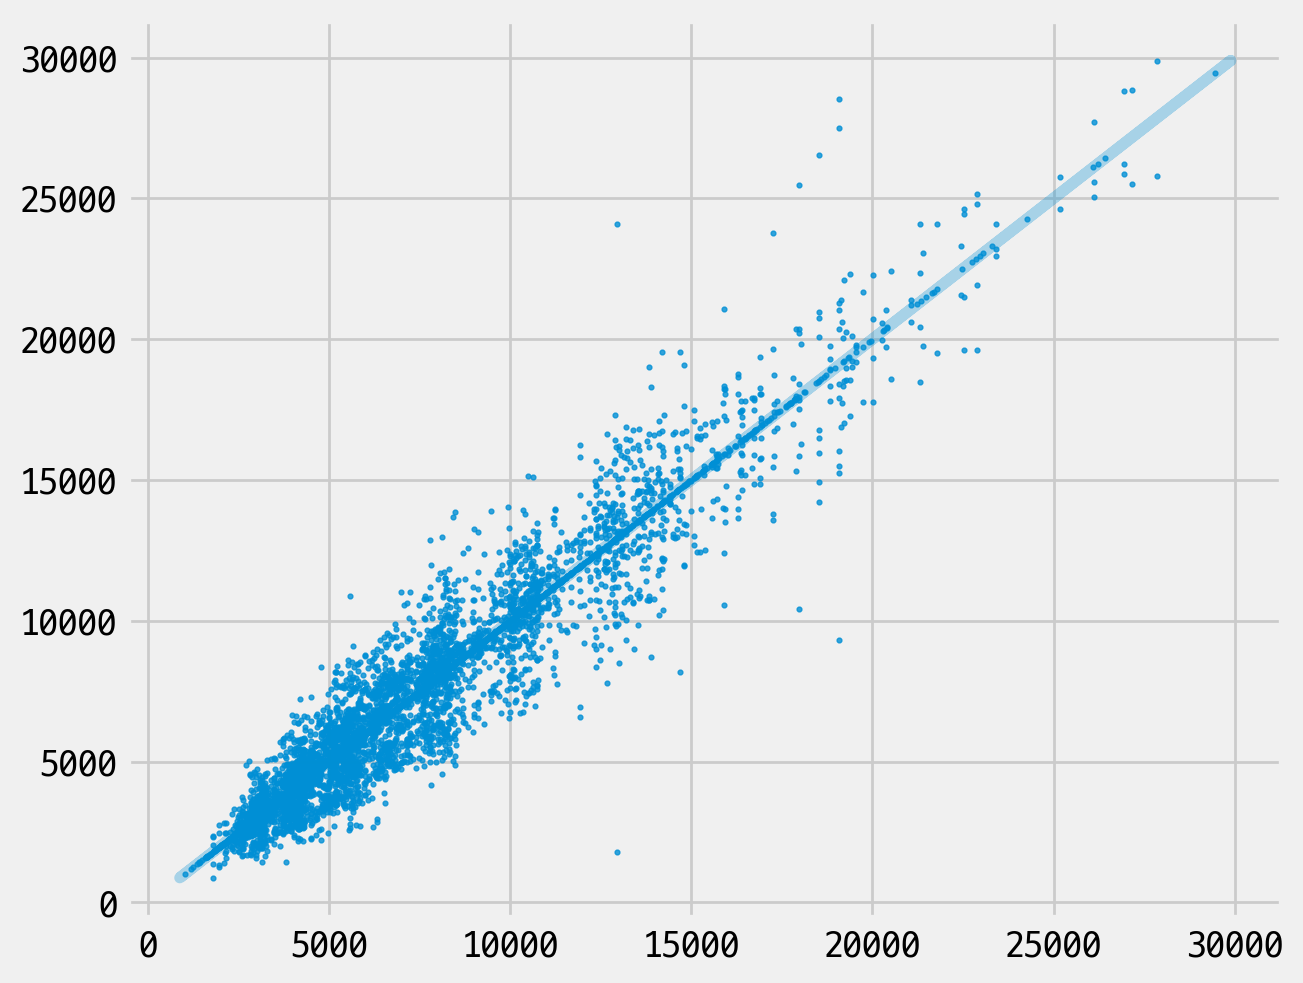

In [102]:
fig,ax = plt.subplots()
ax.plot(y,y,alpha = 0.3)
ax.scatter(y_pred,y,s=3, alpha = 0.8)
pass

7220.0270940443515 4083.740837496106


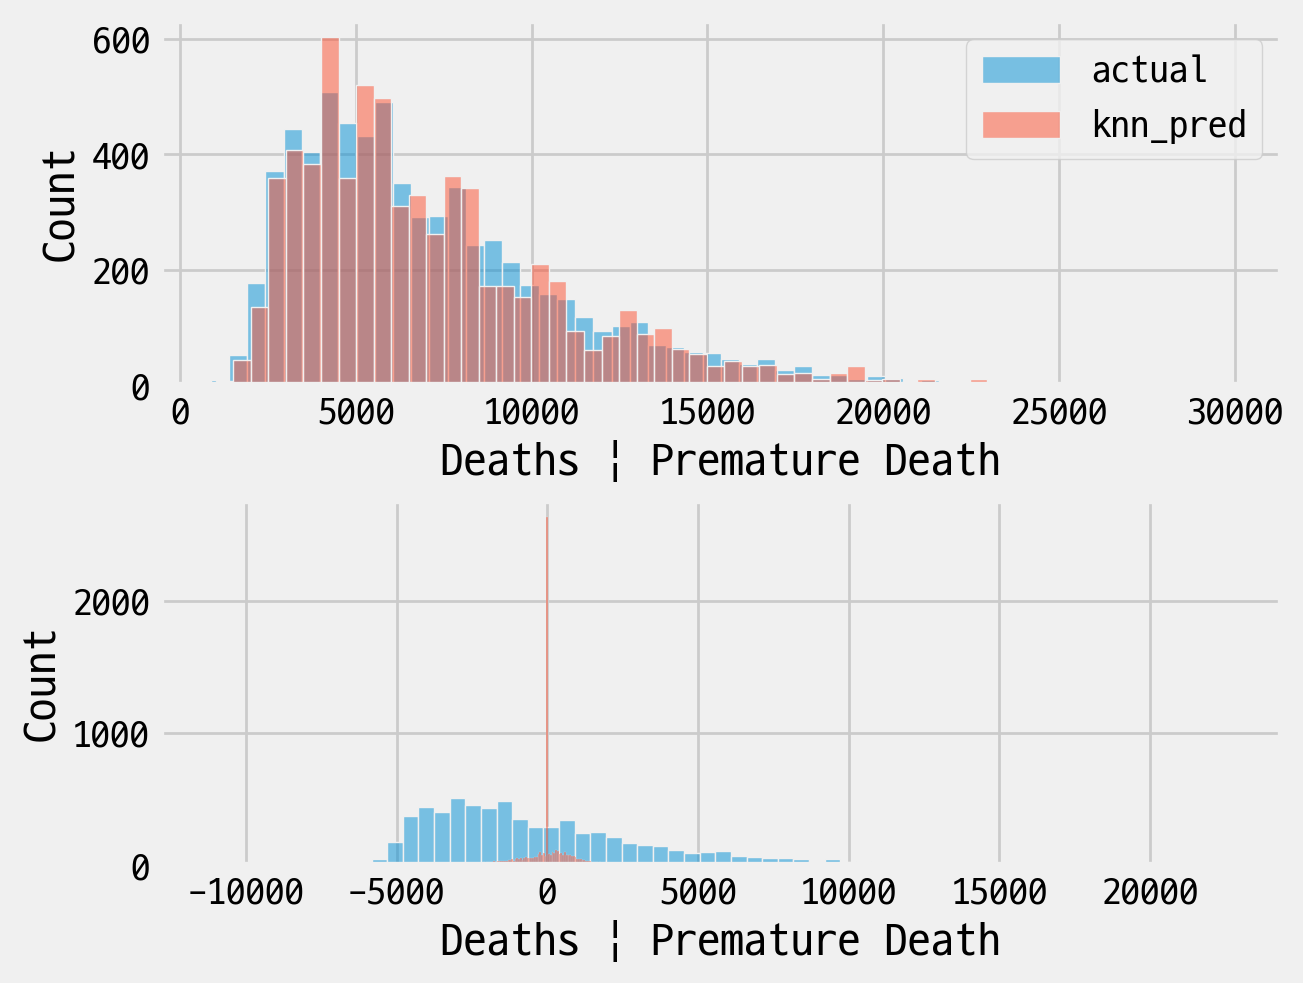

In [103]:
fig,axes = plt.subplots(2,1)
sns.histplot(y,label='actual',ax=axes[0],alpha=0.5)
sns.histplot(y_pred,label='knn_pred',ax=axes[0],alpha=0.5)

sns.histplot(y-np.mean(y),ax=axes[1], label = 'baseline',alpha=0.5)
sns.histplot(y-y_pred,ax=axes[1], label = 'knn_pred',alpha=0.5)
axes[0].legend()

print(y.mean(),y.std())

### train test split and cross validation

In [200]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

In [180]:
train_X, test_X, train_y, test_y = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state=801) #check how to using stratify option

display(train_X.shape)
display(test_X.shape)
display(train_y.shape)
display(test_y .shape)

(5460, 4)

(1365, 4)

(5460,)

(1365,)

In [192]:
knn_model = KNeighborsRegressor(n_neighbors=7,weights='distance',metric=vec_metric_cy_weighted,algorithm='auto')
knn_model.fit(train_X, train_y)

KNeighborsRegressor(metric=<numpy.vectorize object at 0x7f7de1a8f2b0>,
                    n_neighbors=7, weights='distance')

In [193]:
y_pred = knn_model.predict(test_X)

#n=5, 7 둘다 시간/MSE에 큰 차이는 없는 것으로 보임
#k_nn 특성상 train set의 크기가 시간/MSE에 더 큰 영향을 주는 것으로 보임

In [201]:
print(np.sqrt(mean_squared_error(y_pred,test_y)))
print(np.sqrt(mean_squared_error([train_y.mean()]*len(test_y),test_y)))
r2_score(test_y,y_pred)

1594.6763472121118
4027.8392351868088


0.8430551686192889

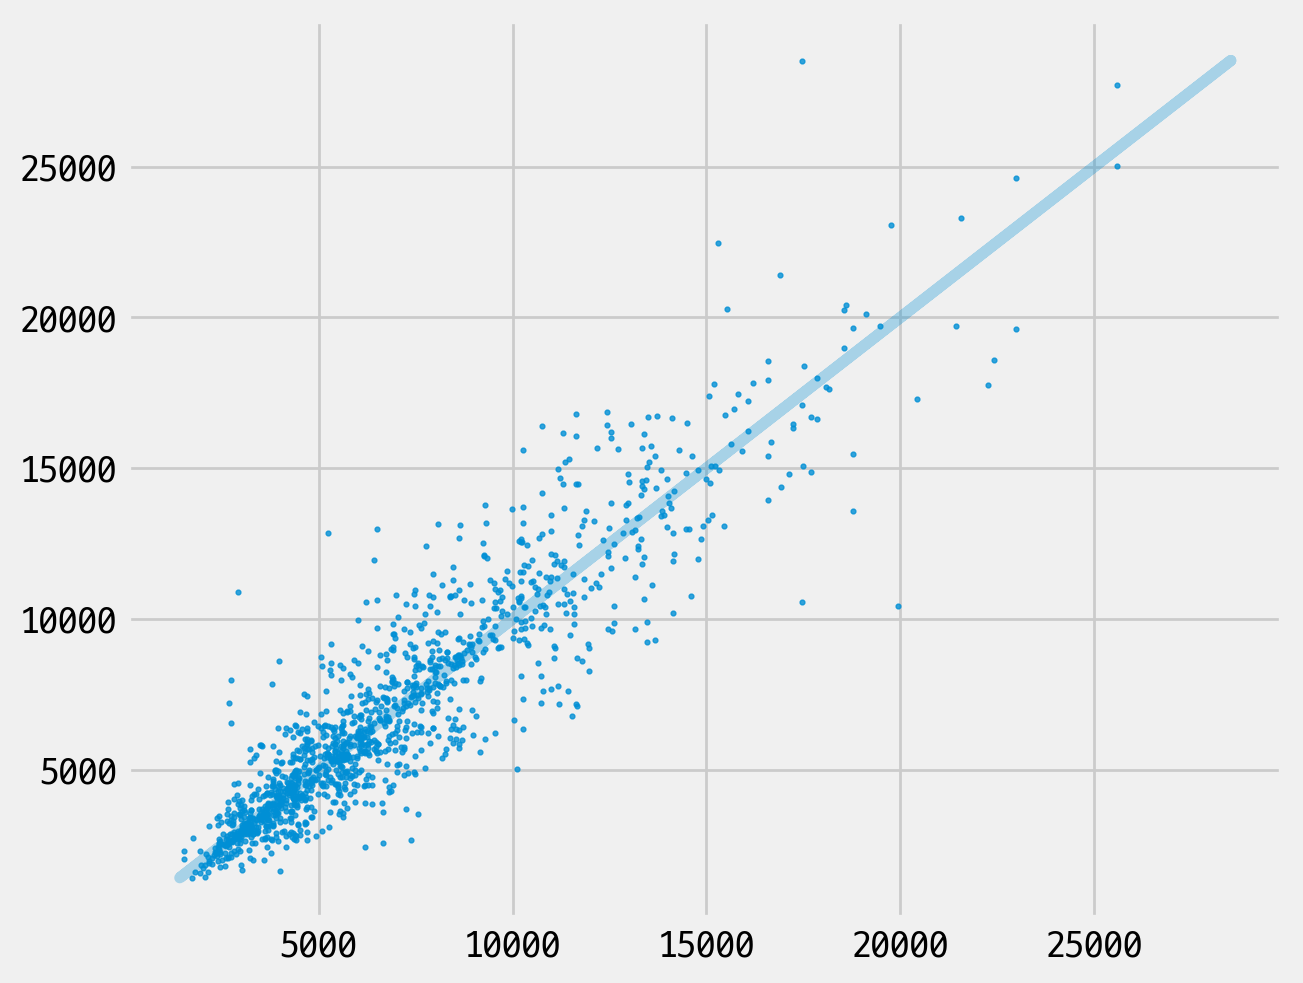

In [198]:
fig,ax = plt.subplots()
ax.plot(test_y,test_y,alpha = 0.3)
ax.scatter(y_pred,test_y,s=3, alpha = 0.8)
pass

7105.79272914359 4026.7826091168167


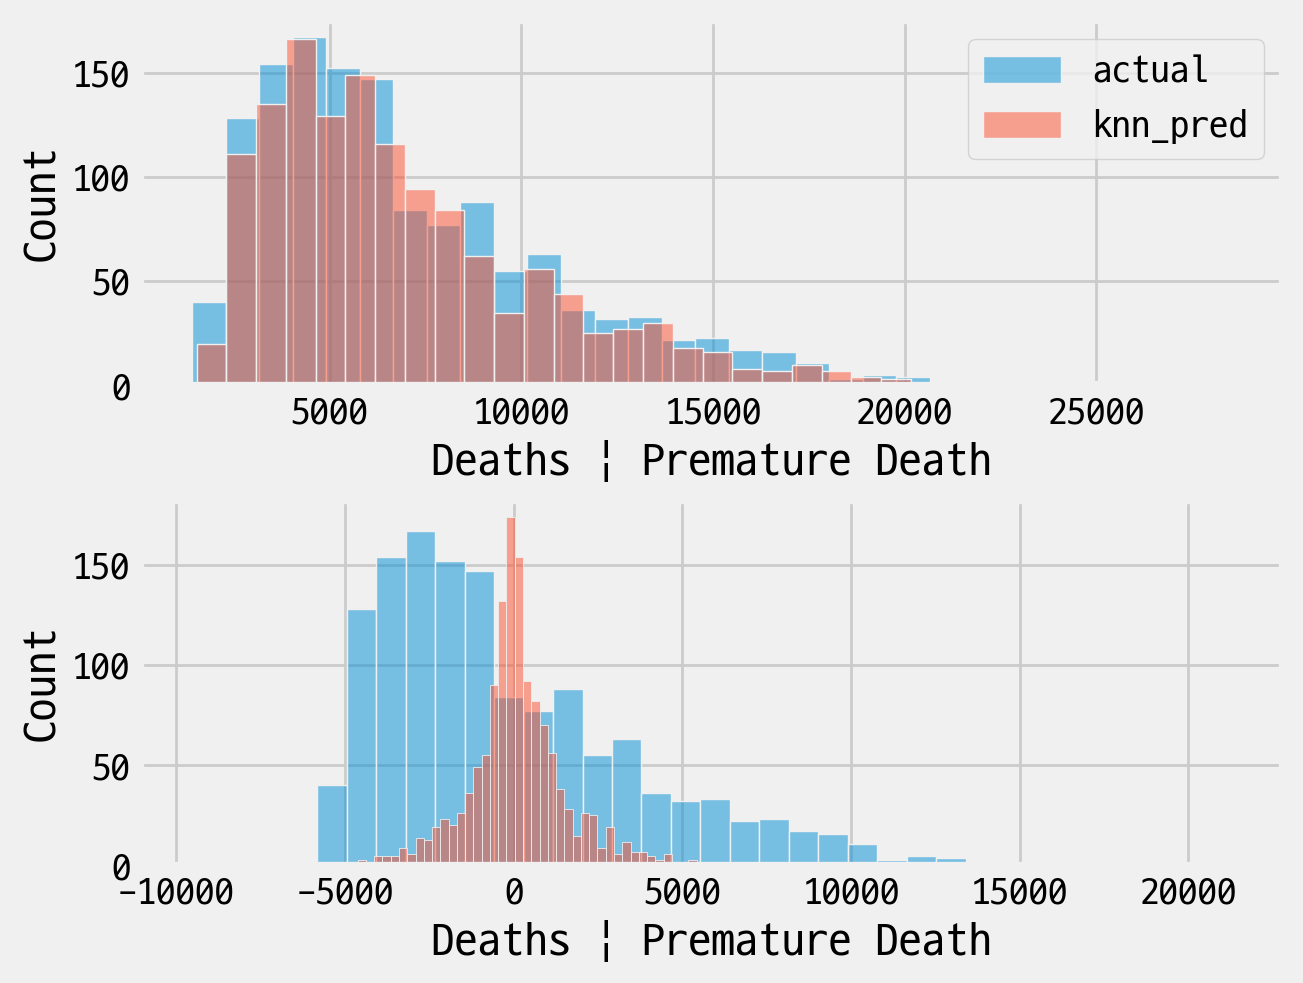

In [199]:
fig,axes = plt.subplots(2,1)
sns.histplot(test_y,label='actual',ax=axes[0],alpha=0.5)
sns.histplot(y_pred,label='knn_pred',ax=axes[0],alpha=0.5)

sns.histplot(test_y-np.mean(train_y),ax=axes[1], label = 'baseline',alpha=0.5)
sns.histplot(test_y-y_pred,ax=axes[1], label = 'knn_pred',alpha=0.5)
axes[0].legend()

print(test_y.mean(),test_y.std())

## check for other labels

In [202]:
test_cols =[
    'Substance Use | Opioid Overdose Deaths',                    
    'Births | Prenatal Care',                                    
    'Life Expectancy at Birth | Life Expectancy',                
    'Sexually Transmitted Disease | HIV/AIDS Prevalence',        
    'Respiratory Infection | Flu Vaccinations, Medicare',        
    'Health Insurance | Uninsured, Child',                       
    'Population | Single-Parent Families',                       
    'Active Transportation | Walking to Work',                   
    'Transportation | Drives Alone to Work',                     
    'Transportation | Public Transportation Use',                
    'Health Insurance | Uninsured, All Ages',                    
    'Deaths | Infant Deaths',                                    
    'Deaths | Maternal Deaths',                                  
    'Births | Preterm Births',                                   
]

In [221]:
test_df = pvtb_entire[['geo_label_city','date_label','strata_race_label','strata_sex_label']+test_cols]
test_df['city_idx'] = test_df['geo_label_city'].apply(lambda x : city_list.index(x))
test_df['race_idx'] = test_df['strata_race_label'].apply(lambda x : entire_race.index(x))
test_df['sex_idx'] = test_df['strata_sex_label'].apply(lambda x : entire_sex.index(x))

/tmp/ipykernel_9847/1684340861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['city_idx'] = test_df['geo_label_city'].apply(lambda x : city_list.index(x))
/tmp/ipykernel_9847/1684340861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['race_idx'] = test_df['strata_race_label'].apply(lambda x : entire_race.index(x))
/tmp/ipykernel_9847/1684340861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [222]:
dict_df = dict()

input_col = ['city_idx','date_label']+['race_idx','sex_idx']

for col in test_cols:
    temp = test_df[input_col+[col]]
    temp_nonan = temp.dropna()
    dict_df[col] = temp_nonan[input_col], temp_nonan[col]

In [223]:
dict_train_test = {
    col: train_test_split(*dict_df[col],
                         test_size = 0.2,
                         random_state=801) #check how to using stratify option
    for col in test_cols}

model = KNeighborsRegressor(n_neighbors=7,weights='distance',metric=vec_metric_cy_weighted,algorithm='auto')
dict_knn, dict_pred = dict(), dict()

In [397]:
import copy, time

for col in test_cols[::2]:
    knn_col = copy.deepcopy(model)
    train_X, test_X, train_y, test_y = dict_train_test[col]
    
    start = time.time()
    knn_col.fit(train_X,train_y)
    y_pred = knn_col.predict(test_X)
    end = time.time()
    
    print (col,'/ n : ',len(train_X),f"/, time : {end-start:.5f} (sec)")
    dict_knn[col], dict_pred[col] = knn_col, y_pred

Substance Use | Opioid Overdose Deaths / n :  3851 /, time : 39.33952 (sec)
Life Expectancy at Birth | Life Expectancy / n :  3993 /, time : 43.87868 (sec)
Respiratory Infection | Flu Vaccinations, Medicare / n :  1596 /, time : 7.13419 (sec)
Population | Single-Parent Families / n :  1764 /, time : 8.42840 (sec)
Transportation | Drives Alone to Work / n :  1764 /, time : 8.37914 (sec)
Health Insurance | Uninsured, All Ages / n :  1680 /, time : 7.50891 (sec)
Deaths | Maternal Deaths / n :  800 /, time : 1.65858 (sec)


In [454]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

In [537]:
dict_score = dict()

for col in test_cols[::2]:
    train_X, test_X, train_y, test_y = dict_train_test[col]
    rmse_model = np.sqrt(mse(dict_pred[col],test_y))
    rmse_base = np.sqrt(mse([train_y.mean()]*len(test_y),test_y))
    msle_model = msle(dict_pred[col],test_y)
    msle_base = msle([train_y.mean()]*len(test_y),test_y)
    mape_model = (mape(dict_pred[col],test_y))
    mape_base = (mape([train_y.mean()]*len(test_y),test_y))
    r2_model = r2_score(test_y,dict_pred[col])
    r2_base = r2_score([train_y.mean()]*len(test_y),dict_pred[col])
    dict_score[col] = {
        'rmse' : [rmse_model, rmse_base],
        'msle' : [msle_model, msle_base],
        'mape' : [mape_model, mape_base],
        'r2_score' : [r2_model,r2_base]
    }
    print('{}\nr2 score : {:.5f}'.format(col,r2_model))
    print('rmse_model : {:.5f} / rmse_base : {:.5f}\t'.format(*dict_score[col]['rmse']),
          'mape_model : {:.5f} / mape_base : {:.5f}\t'.format(*dict_score[col]['mape']),
          'msle_model : {:.5f} / msle_base : {:.5f}'.format(*dict_score[col]['msle']))
    print('-'*150)

Substance Use | Opioid Overdose Deaths
r2 score : 0.58585
rmse_model : 18.23834 / rmse_base : 28.40608	 mape_model : 0.50710 / mape_base : 0.83497	 msle_model : 0.31025 / msle_base : 0.97675
------------------------------------------------------------------------------------------------------------------------------------------------------
Life Expectancy at Birth | Life Expectancy
r2 score : 0.84981
rmse_model : 2.05653 / rmse_base : 5.30834	 mape_model : 0.02012 / mape_base : 0.05405	 msle_model : 0.00069 / msle_base : 0.00468
------------------------------------------------------------------------------------------------------------------------------------------------------
Respiratory Infection | Flu Vaccinations, Medicare
r2 score : 0.81095
rmse_model : 4.25387 / rmse_base : 9.78970	 mape_model : 0.07807 / mape_base : 0.19567	 msle_model : 0.01071 / msle_base : 0.05867
-----------------------------------------------------------------------------------------------------------------

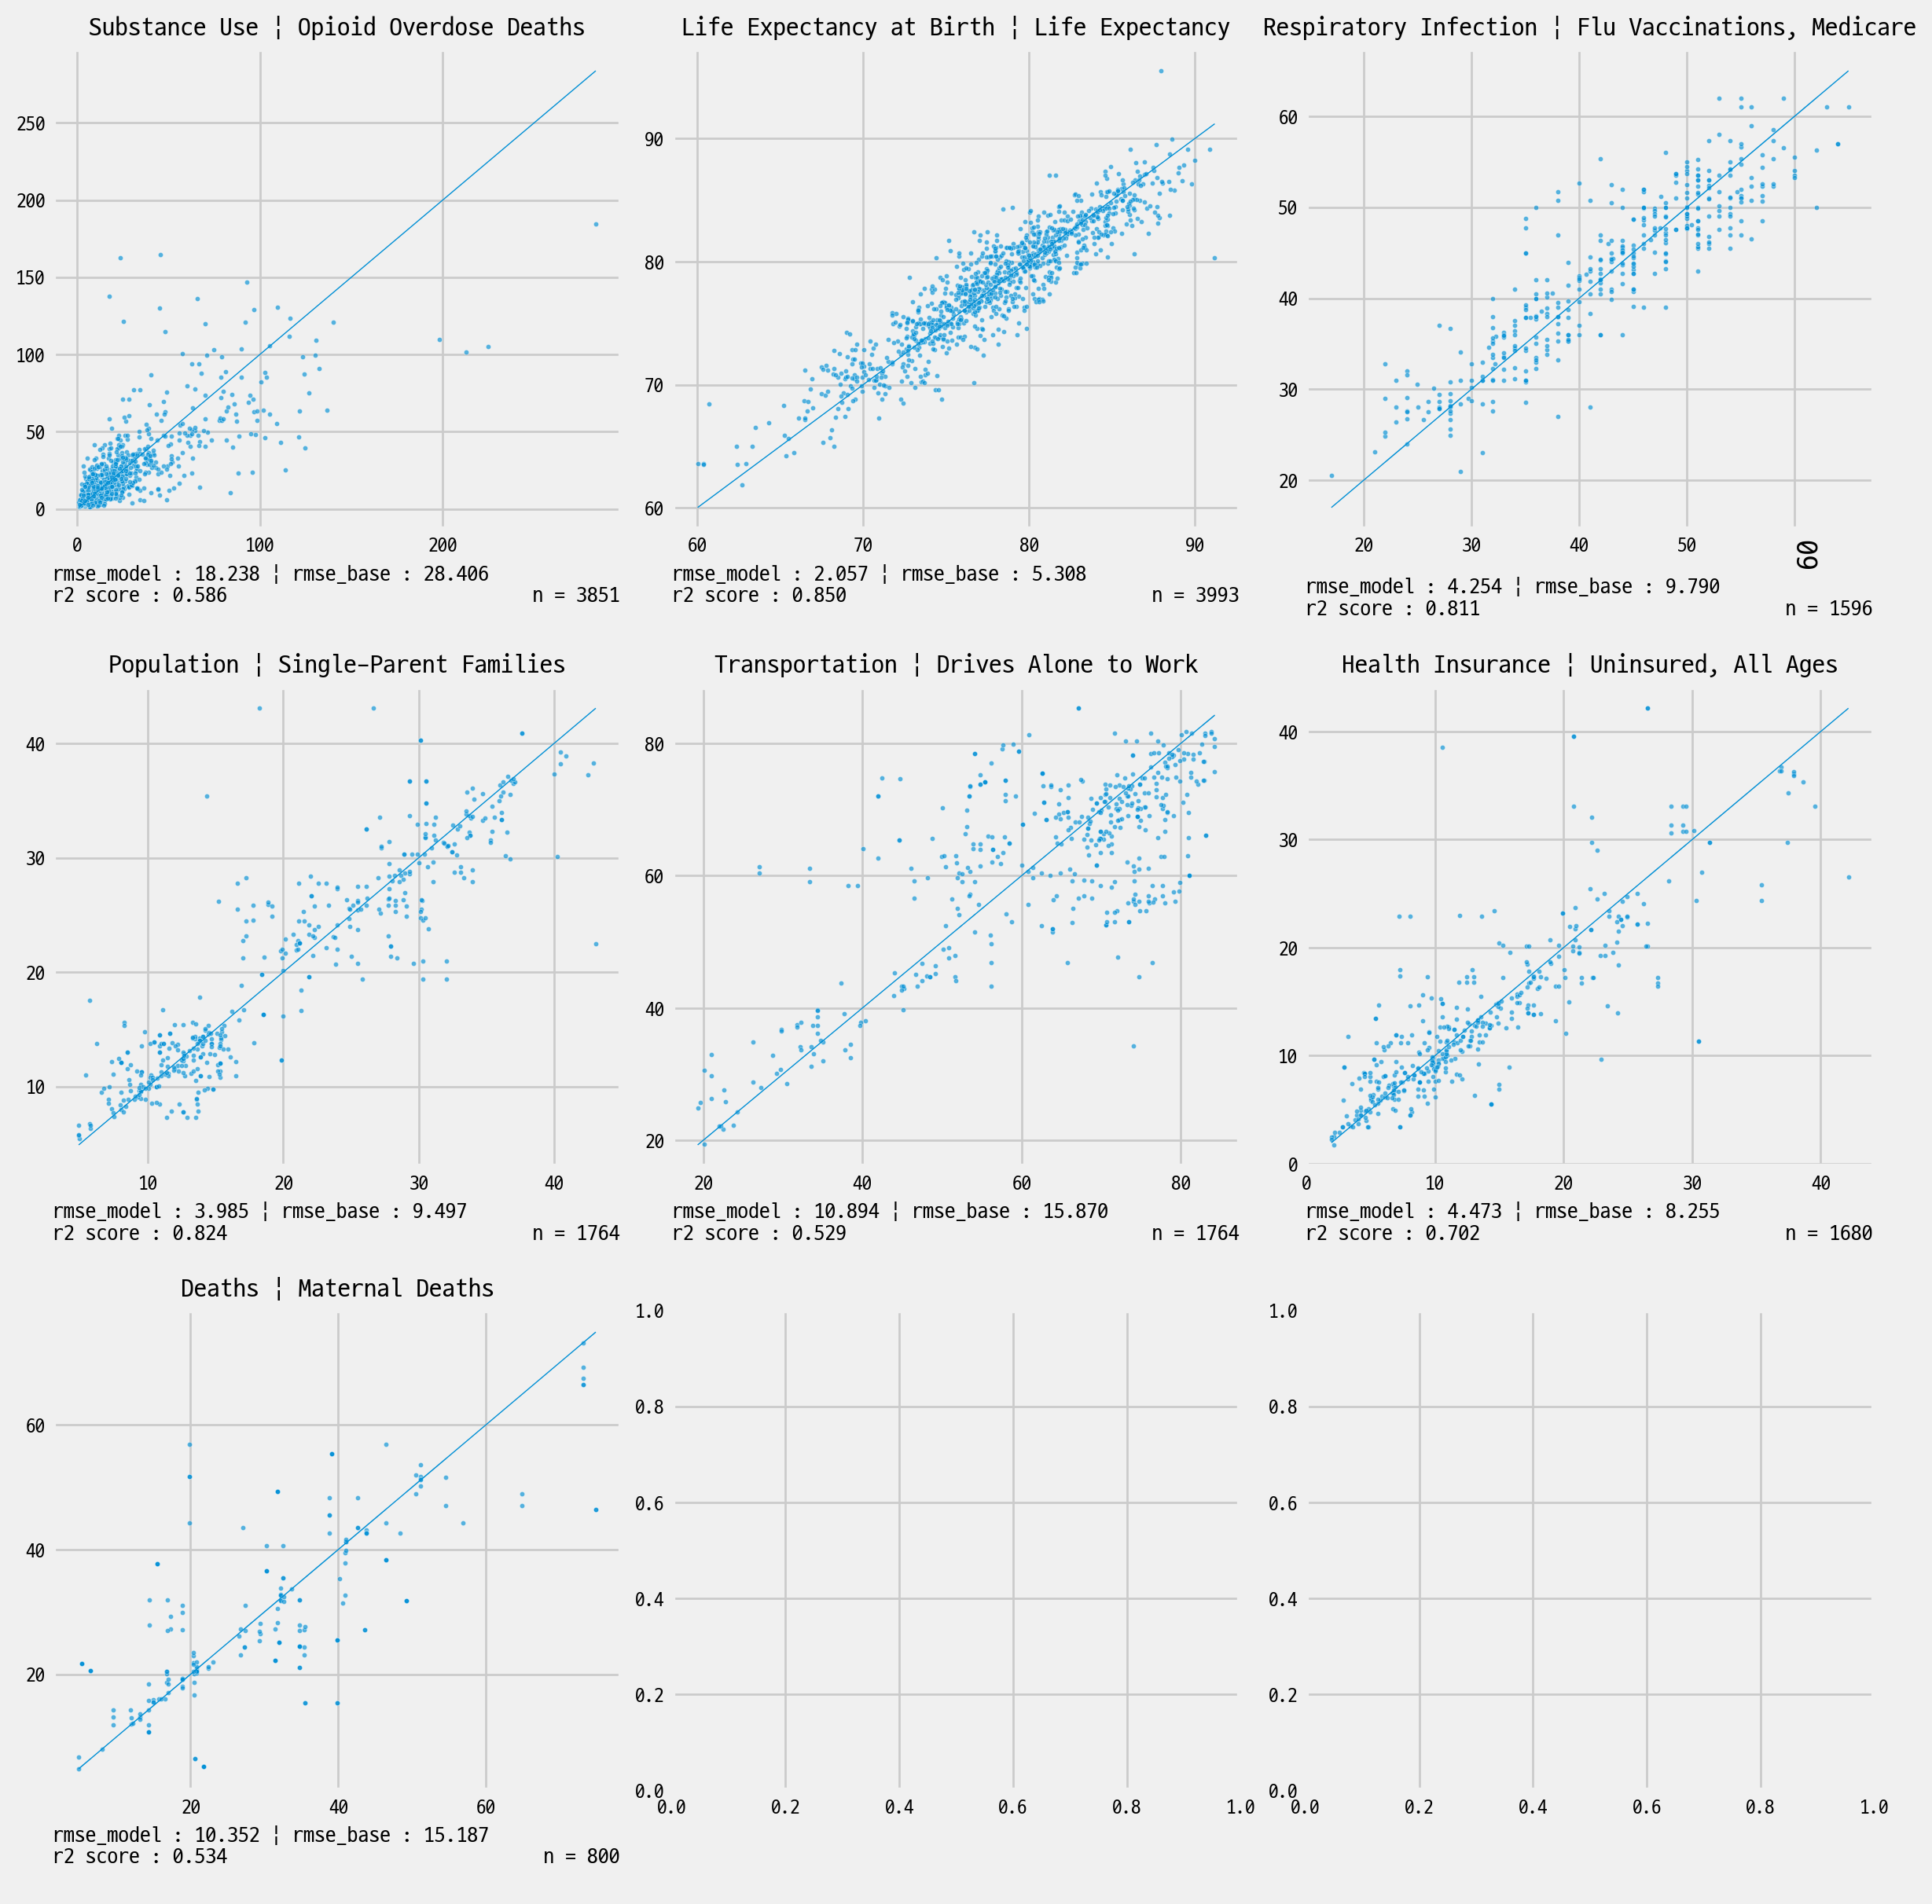

In [498]:
# x = data.iloc[n].index, y = data.iloc[n].values

data_plot ={
    col : (dict_train_test[col][3], dict_pred[col])
    for col in test_cols[::2]
}
data_line = {
    col : (dict_train_test[col][3],dict_train_test[col][3])
    for col in test_cols[::2]
}

fig,axes = plt.subplots(3,3,figsize=(12,12))
fig,axes = pair_plot_feat_hue(fig=fig,axes=axes,data=data_line,
#fig,axes = pair_plot_feat_hue(fig=None,axes=None,data=data_line,
                              pair_plot=sns.lineplot,lw=0.5)
#fig.set_size_inches(12,8, forward=True)
#왠지 모르게 저걸 설정하면 망가짐 
fig,axes = pair_plot_feat_hue(fig=fig,axes=axes,data=data_plot,
                              pair_plot=sns.scatterplot,s=5,alpha=0.65)

for n,key in enumerate(data_plot.keys()):
    ax = axes.flatten()[n]
    ax.set_ylabel('')
    ax.set_title(key,fontsize=12)
    ax.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>35}\n'.format(*dict_score[key]['rmse'],dict_score[key]['r2_score'][0],
        f'n = {len(dict_train_test[key][0])}'), fontsize=10, ha ='left')

for ax in axes.flatten():
    plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
    plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)
#    print(ax.get_yticklabels())
#    print('-'*30)

#print(axes.flatten()[2].get_yticklabels())

In [395]:
ax = axes.flatten()[2]
ax.get_yticklabels()

[Text(0, 0.0, '0'),
 Text(0, 10.0, '10'),
 Text(0, 20.0, '20'),
 Text(0, 30.0, '30'),
 Text(0, 40.0, '40'),
 Text(0, 50.0, '50')]

In [506]:
df_score = pd.DataFrame(dict_score[test_cols[0]]).T[[1,0]]
df_score

,1,0
rmse,28.406076,18.238338
mape,0.834974,0.507099
msle,0.976750,0.310252
r2_score,0.000000,0.585849


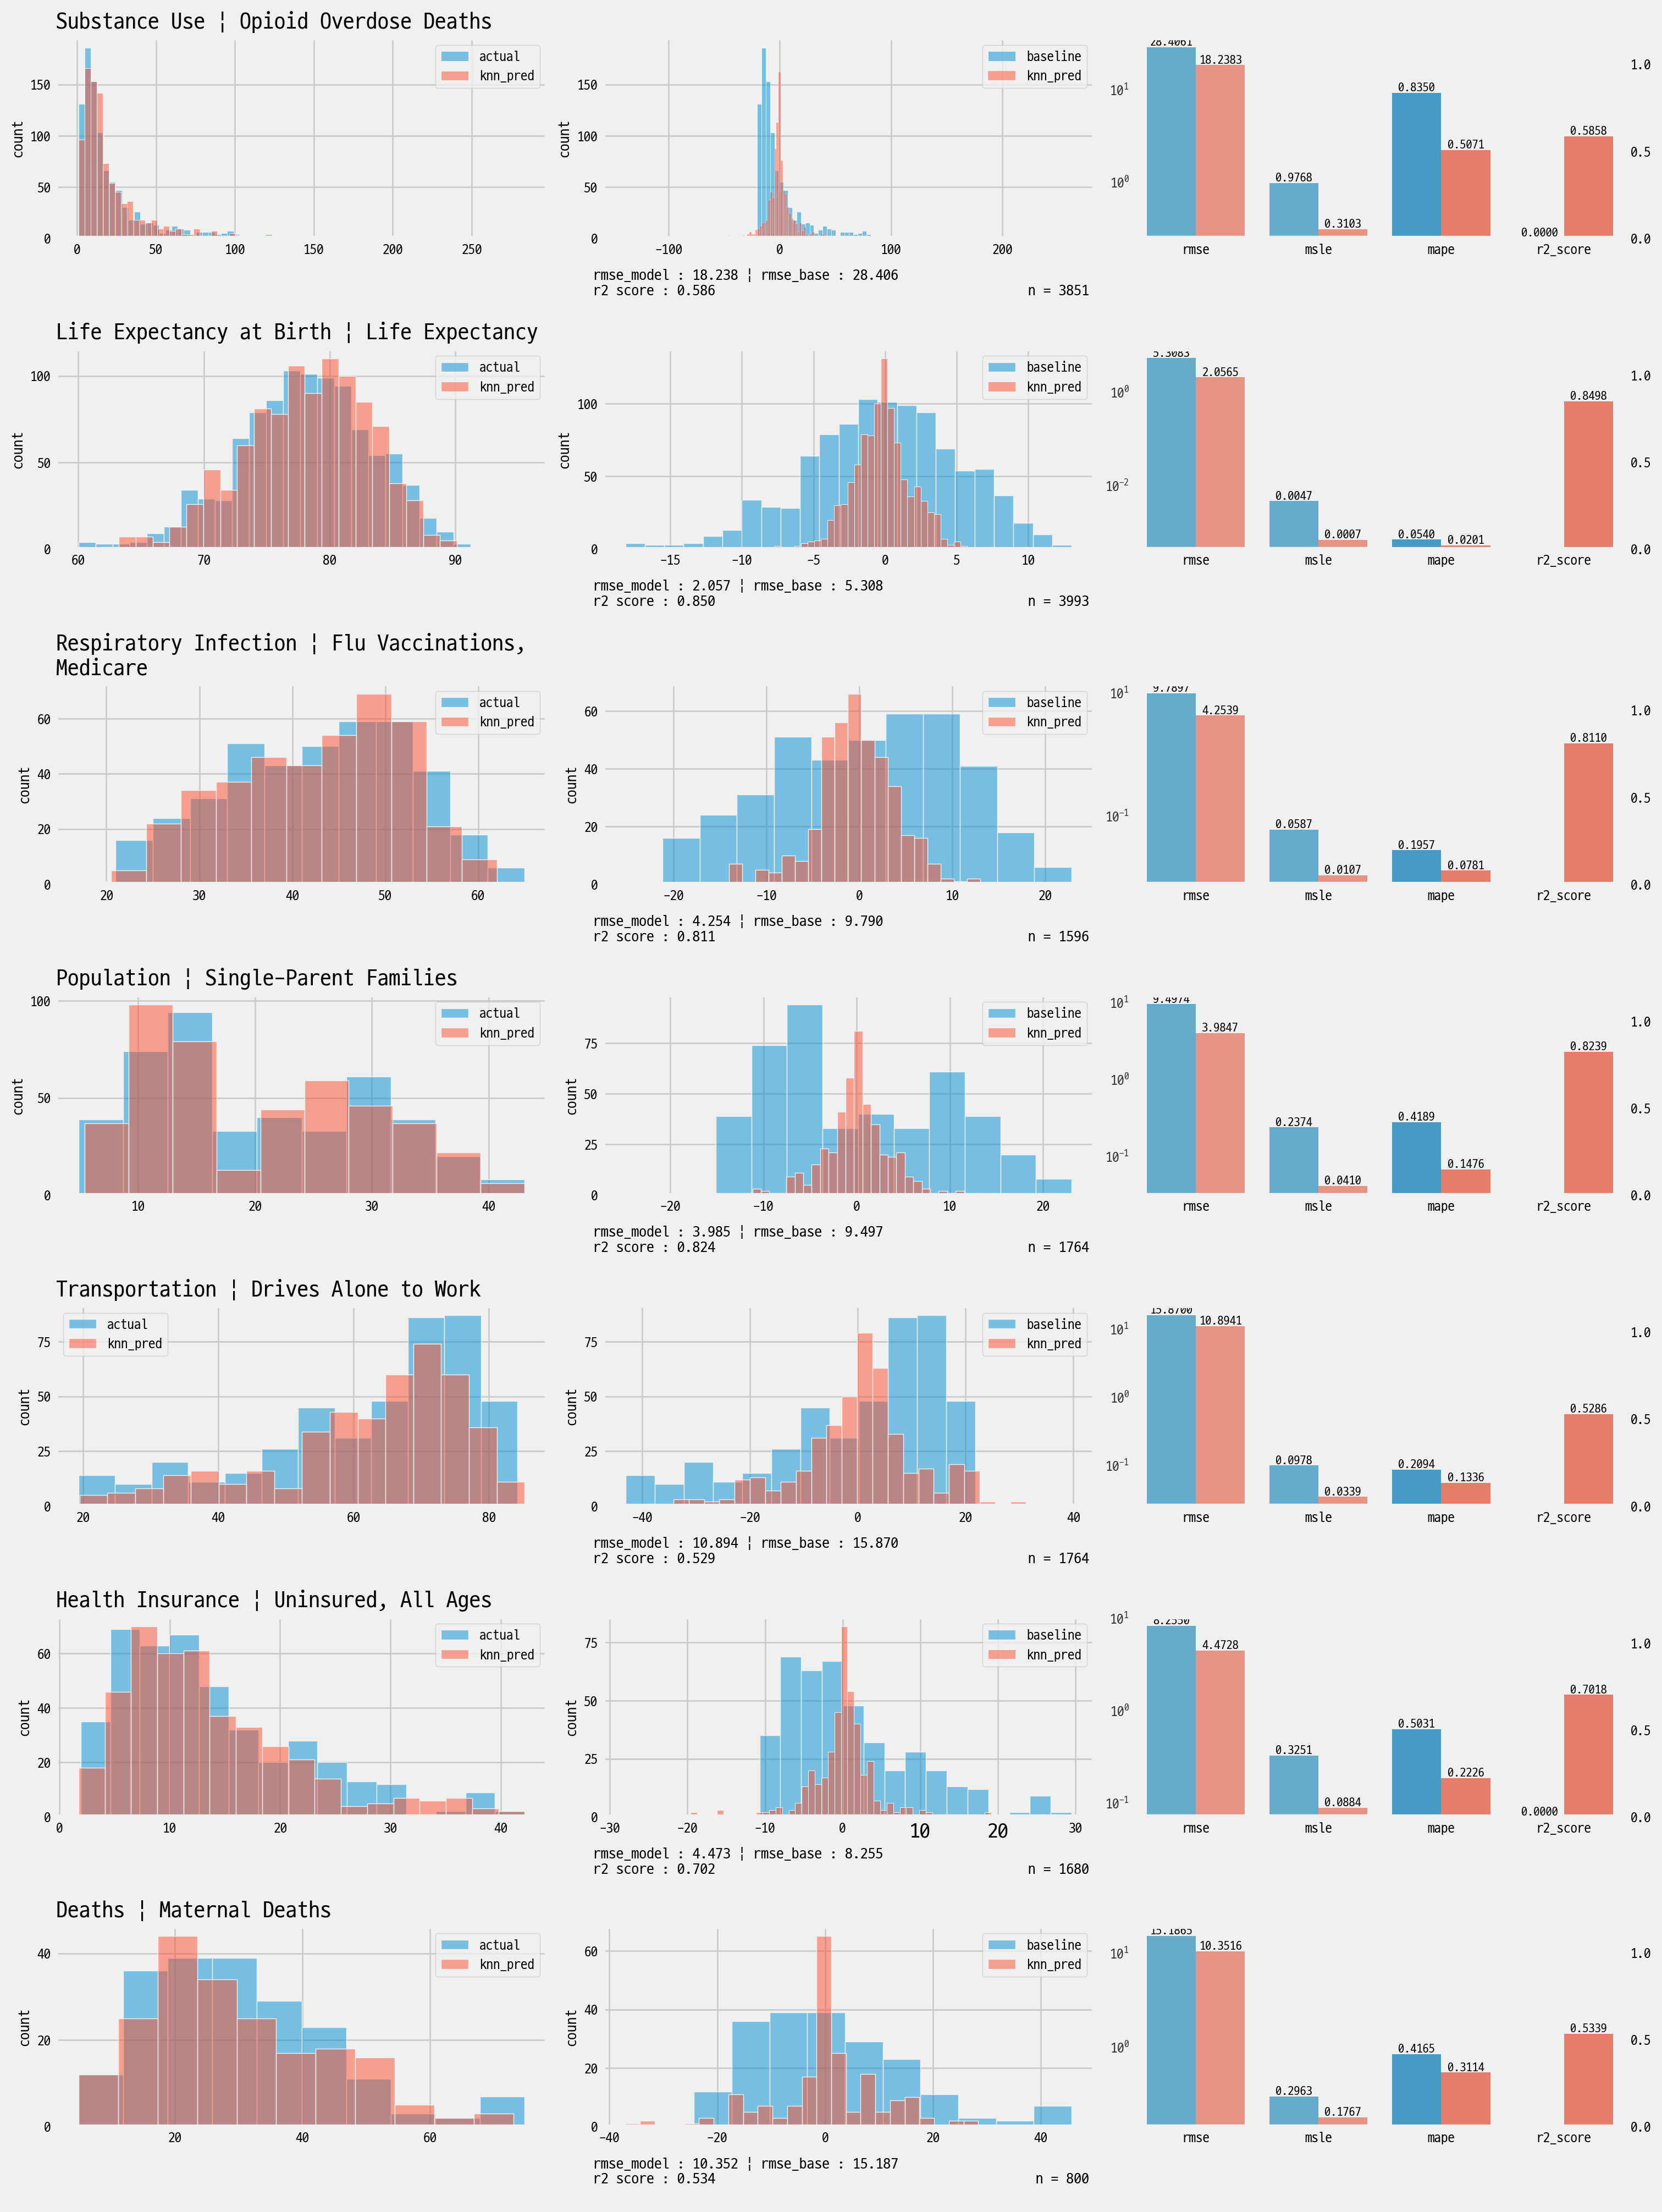

In [546]:
from itertools import repeat, chain

fig,axes = plt.subplots(len(data_plot),3,figsize=(15,20))
for n, col in enumerate(data_plot.keys()):
    #quo, rem = divmod(n,3)
    ax1, ax2, ax3 = axes[n][0], axes[n][1], axes[n][2]
    test_y, y_pred = data_plot[col]
    train_y = dict_train_test[col][2]
    
    sns.histplot(test_y,label='actual',ax=ax1,alpha=0.5)
    sns.histplot(y_pred,label='knn_pred',ax=ax1,alpha=0.5)
    ax1.legend(fontsize=9)
    
    sns.histplot(test_y-np.mean(train_y),ax=ax2, label = 'baseline',alpha=0.5)
    sns.histplot(test_y-y_pred,ax=ax2, label = 'knn_pred',alpha=0.5)
    ax2.legend(fontsize=9)
    
    df_score = pd.DataFrame(dict_score[col]).T[[1,0]]
    xs = list(chain.from_iterable(repeat(val,2) for val in df_score.index))
    ax3r = ax3.twinx()
    sns.barplot(x=xs[:4],y=list(df_score.values.reshape(-1))[:4],
                hue = ['knn_pred','base']*2,ax=ax3,alpha=0.65,legend=False)
    sns.barplot(x=xs[4:],y=list(df_score.values.reshape(-1))[4:],
                hue = ['knn_pred','base']*2,ax=ax3r,alpha=0.8,legend=False)
    ax3.set_yscale('log')
    ax3r.set_ylim([0.0,1.15])
    ax3r.bar_label(ax3r.containers[0], fontsize=8, fmt='%.4f')
    ax3r.bar_label(ax3r.containers[1], fontsize=8, fmt='%.4f')
    ax3.grid(False)
    ax3r.grid(False)
    ax3r.set_yscale('linear')    
    ax3.bar_label(ax3.containers[0], fontsize=8, fmt='%.4f')
    ax3.bar_label(ax3.containers[1], fontsize=8, fmt='%.4f')
    #ax3.axvline()
    
    ax1.set_title(str_cutter(col,50),fontsize=15,loc='left',ha='left')
    ax2.xaxis.set_label_coords(-0.02, -0.15)
    ax2.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>48}\n'.format(*dict_score[col]['rmse'],dict_score[col]['r2_score'][0],
        f'n = {len(dict_train_test[col][0])}'), fontsize=10,ha ='left')
    #ax2.xaxis.set_label_position('left')
    ax1.set_xlabel('')
    ax3.set_xlabel('')
    ax1.set_ylabel('count',fontsize =10) 
    ax2.set_ylabel('count',fontsize =10) 
    plt.setp(ax3.get_yticklabels(),rotation = 0, fontsize = 9, color='#333333')
    plt.setp(ax3r.get_yticklabels(),rotation = 0, fontsize = 9)

for ax in axes.flatten():
    plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
    plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)

cf. 누락율이 꽤나 높음에도 예상보다 잘 맞춤
- 단 해당 칼럼들은 race-sex집단에서 stratified 된 집단이 각 도시/연도 별로 최소 하나는 있는 도시/연도가 50% 이상임
- 위의 비율 기준, 118개 중 상위 30 ~ 44 위의 label들 (100% ~ 53.8%)
- 45위 부터는 25% 미만으로 떨어짐

    (구체적 내용 : 240619_check_missing_entire.ipynb)
- 현재 연도를 많이 보지 않으니, 도시 기준으로 분포하는 비율을 봐서, 추가적인 후보를 추릴 수 있을 것 같음

<Axes: >

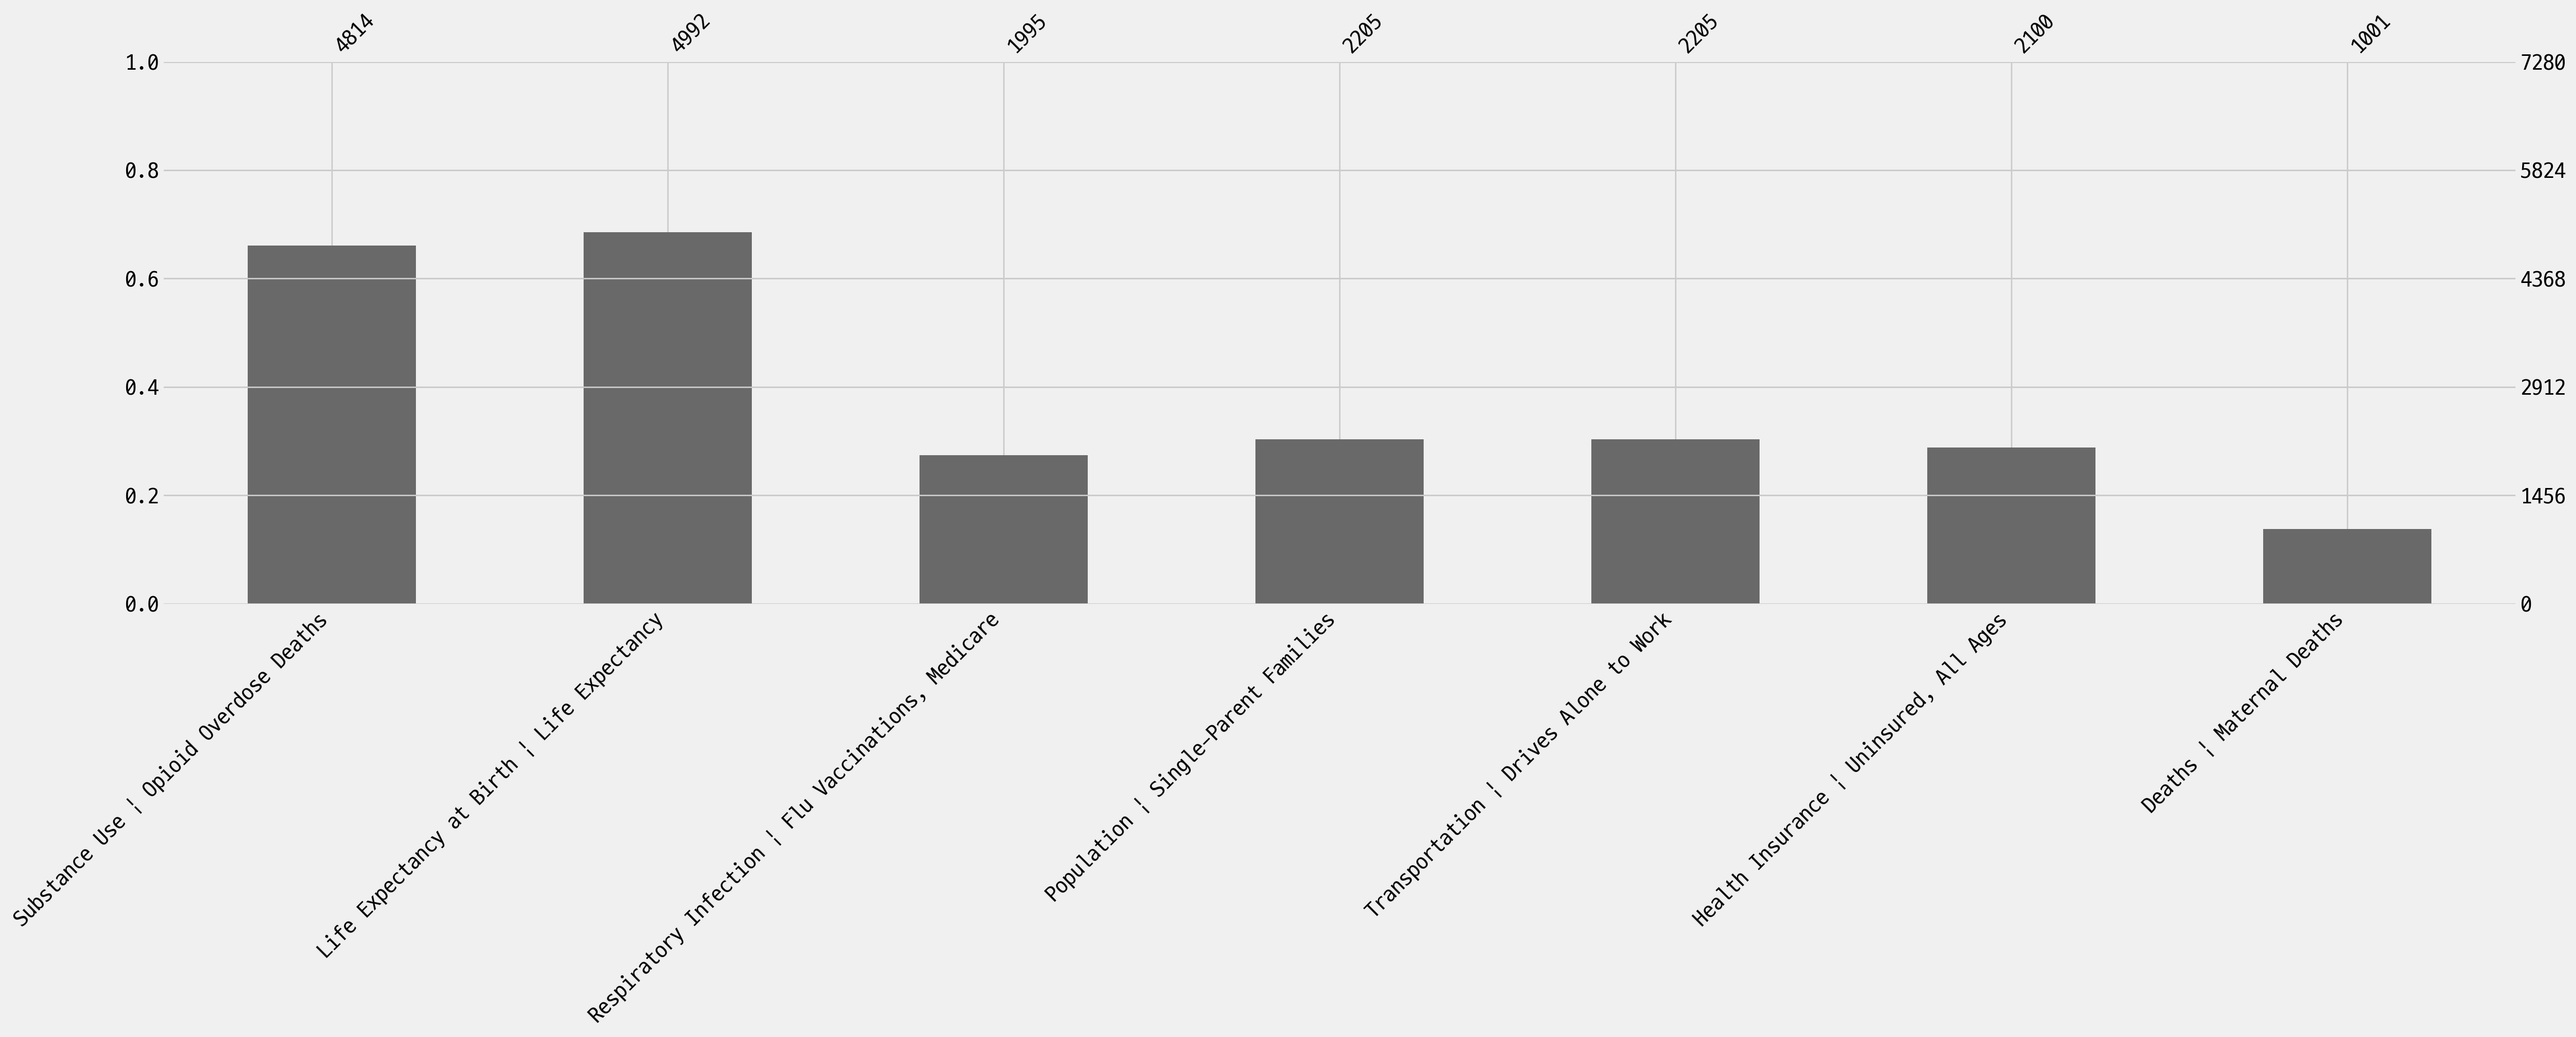

In [451]:
msno.bar(pvtb_entire[list(data_plot.keys())])

## TODO : refactoring

## TODO : other models 

In [ ]:
df_geo_info

,geo_label_state,geo_label_citystate,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,count
geo_label_city,,,,,,,,
New York City,NY,"New York City, NY",Northeast,Less poor cities (<18% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6535
Houston,TX,"Houston, TX",South,Poorest cities (18%+ poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),6431
Los Angeles,CA,"Los Angeles, CA",West,Less poor cities (<18% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),6372
Philadelphia,PA,"Philadelphia, PA",Northeast,Poorest cities (18%+ poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6310
San Diego,CA,"San Diego, CA",West,Less poor cities (<18% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),6251
Chicago,IL,"Chicago, IL",Midwest,Less poor cities (<18% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),6210
San Francisco,CA,"San Francisco, CA",West,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Less Segregated (<50%),6121
Las Vegas,NV,"Las Vegas, NV",West,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),5848
Boston,MA,"Boston, MA",Northeast,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),5718


In [ ]:
for col in geo_strat_cols:
    test_nonan[col] = test_nonan['geo_label_city'].apply(lambda x: df_geo_info.loc[x,col])
    #test_nonan[col+'2'] = df_geo_info.loc[test_nonan['geo_label_city'],col]

/tmp/ipykernel_1962/920039715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_nonan[col] = test_nonan['geo_label_city'].apply(lambda x: df_geo_info.loc[x,col])
/tmp/ipykernel_1962/920039715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_nonan[col] = test_nonan['geo_label_city'].apply(lambda x: df_geo_info.loc[x,col])
/tmp/ipykernel_1962/920039715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [ ]:
test_nonan.dropna()

,geo_label_city,date_label,Deaths | Premature Death,city_idx,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation
0,Austin,2010,5094.792265,20,South,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%)
1,Austin,2010,3807.898474,20,South,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%)
2,Austin,2010,6377.256790,20,South,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%)
3,Austin,2010,2579.797021,20,South,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%)
4,Austin,2010,2025.151915,20,South,Less poor cities (<18% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%)
...,...,...,...,...,...,...,...,...,...
7274,Washington,2022,2692.047582,16,South,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+)
7275,Washington,2022,6300.589535,16,South,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+)
7277,Washington,2022,2231.116039,16,South,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+)
7278,Washington,2022,1609.792900,16,South,Less poor cities (<18% poor),Smaller (<1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+)


In [ ]:
X = test_nonan[geo_strat_cols+['date_label']]

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_test = DecisionTreeRegressor()

In [ ]:
y_tree = tree_test.fit(X,y)
#tree regression model은 string은 넣지 못함

ValueError: could not convert string to float: 'South'